# Spiral

> Enzo Sergiani

- Create a neural network to classify the two classes.
- Display the area of each class based on the code of Admission classification labwork.
- Challenge : Create a video of the training evolution (in this case, upload a zip file with the notebook and the video).


## Librairies


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from matplotlib.colors import ListedColormap
from IPython.display import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, Callback

## Données


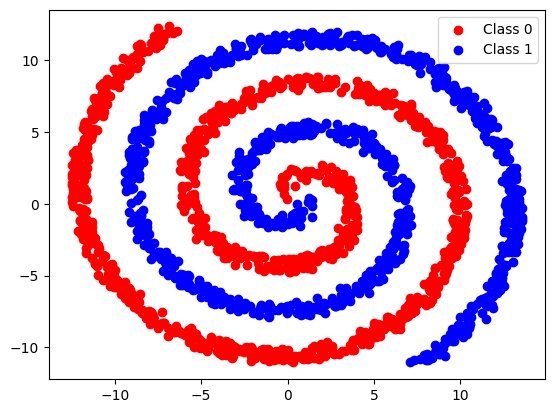

In [54]:
def generate_spiral_data(points, noise=1.0):
    n = np.sqrt(np.random.rand(points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(points, 1) * noise
    X1 = np.hstack((d1x, d1y))

    d2x = np.cos(n) * n + np.random.rand(points, 1) * noise
    d2y = -np.sin(n) * n + np.random.rand(points, 1) * noise
    X2 = np.hstack((d2x, d2y))

    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(points), np.ones(points)))

    return X, y


# Generate the data
X, y = generate_spiral_data(1000)

# Plot the data
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color="red", label="Class 0")
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="blue", label="Class 1")
plt.legend()
plt.show()

## Modèle

In [60]:
model = Sequential()
model.add(Dense(16, input_dim=2, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"]
)

model.summary()

/home/enzo/dev/artificial_intelligence/tp/.env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

## Calcul


In [56]:
from sklearn.metrics import confusion_matrix


class DecisionBoundaryCallback(Callback):
    def __init__(self, X, y, image_folder):
        self.X = X
        self.y = y
        self.image_folder = image_folder
        self.losses = []
        self.accuracies = []
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        else:
            os.system(f"rm -rf {image_folder}/*")

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs["loss"])
        self.accuracies.append(logs["accuracy"])

        x_min, x_max = self.X[:, 0].min() - 1, self.X[:, 0].max() + 1
        y_min, y_max = self.X[:, 1].min() - 1, self.X[:, 1].max() + 1

        plot_step = 0.1

        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        Z = self.model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        sns.scatterplot(
            x=self.X[:, 0],
            y=self.X[:, 1],
            hue=self.y,
            edgecolor="k",
            marker="o",
            palette={0.0: "blue", 1.0: "red"},
            ax=ax[0],
        )

        ax[0].pcolormesh(
            xx, yy, Z, cmap=ListedColormap(["blue", "red"]), shading="auto", alpha=0.3
        )

        ax[0].legend(["Classe 0", "Classe 1"])
        ax[0].set_title(f"Decision Boundary")

        ax[1].plot(range(1, epoch + 2), self.losses, label="Loss")
        ax[1].plot(range(1, epoch + 2), self.accuracies, label="Accuracy")
        ax[1].set_title("Loss and Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Value")
        ax[1].grid(True, alpha=0.3)
        ax[1].legend()

        y_pred = (self.model.predict(self.X) > 0.5).astype("int32")
        cm = confusion_matrix(self.y, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="RdYlGn",
            ax=ax[2],
            xticklabels=["Classe 0", "Classe 1"],
            yticklabels=["Classe 0", "Classe 1"],
        )
        ax[2].set_title("Confusion Matrix")
        ax[2].set_xlabel("Predicted")
        ax[2].set_ylabel("Actual")

        plt.suptitle(f"Epoch {epoch + 1}")
        plt.savefig(os.path.join(self.image_folder, f"plot_epoch_{epoch + 1}.png"))
        plt.close()

In [57]:
image_folder = "./screenshot/"
decision_boundary_callback = DecisionBoundaryCallback(X, y, image_folder)
early_stopping = EarlyStopping(monitor="loss", patience=10)
tensorboard = TensorBoard(log_dir="./logs")

model.fit(
    X,
    y,
    epochs=70,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, tensorboard, decision_boundary_callback],
)

Epoch 1/70
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5560 - loss: 0.7845
Epoch 2/70
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 2s 725us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6494 - loss: 0.6233
Epoch 3/70
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 2s 710us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6722 - loss: 0.6240
Epoch 4/70
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6615 - loss: 0.6192
Epoch 5/70
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6247 - loss: 0.6223
Epoch 6/70
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accura

## Résultat


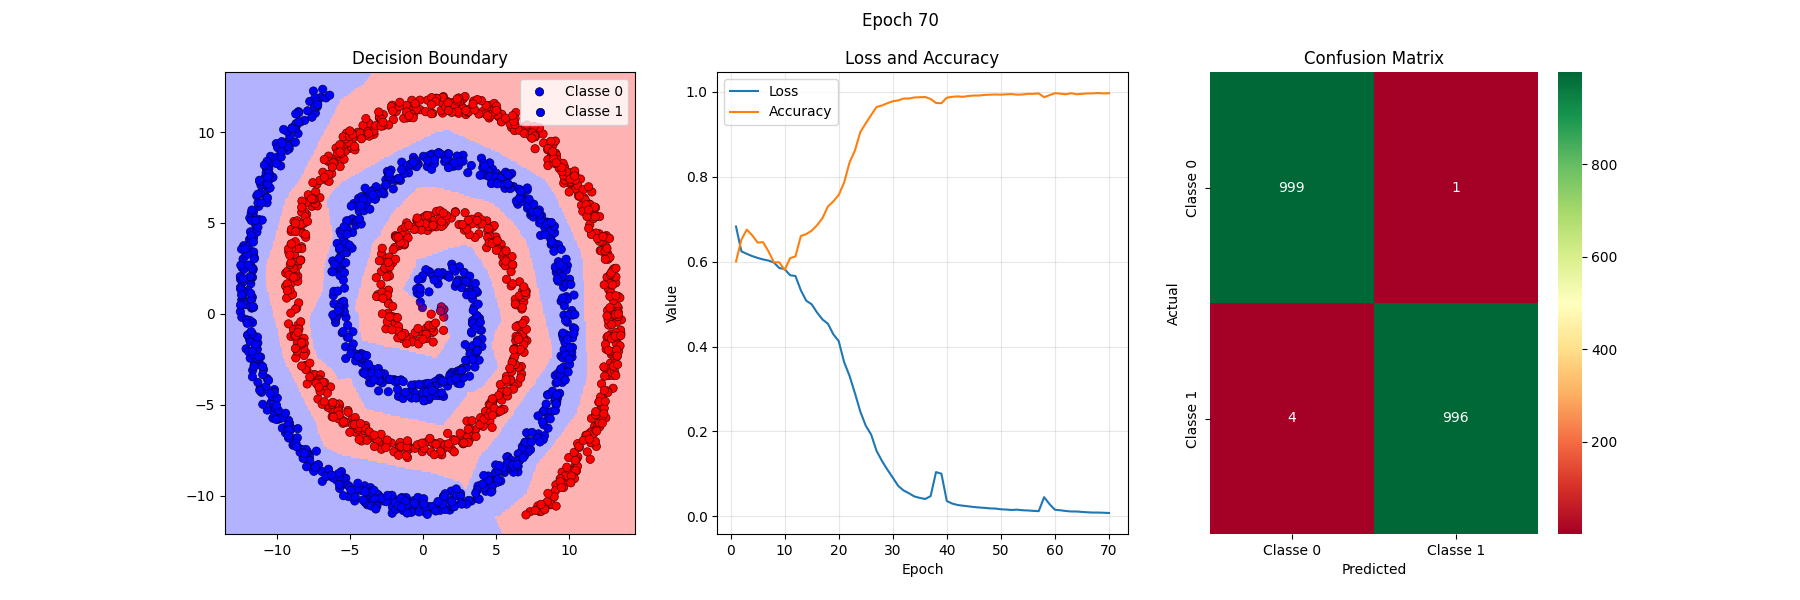

In [58]:
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))

last_image_path = os.path.join(image_folder, images[-1])
display(Image(filename=last_image_path))

## Video d'entraînement


In [59]:
# Création de la vidéo
video_name = "training_evolution.mp4"
fps = 5

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()